# Прогнозирование спроса на заказы такси с помощью Apache Spark
## 1.Набор данных

Раньше для вызова такси приходилось звонить на разные номера диспетчерских служб и ждать подачу машины полчаса или даже больше. Теперь сервисы такси хорошо автоматизированы, а среднее время подачи автомобиля Яндекс.Такси в Москве около 3-4 минут. Наверное самые важные вопросы это как научиться прогнозировать высокий спрос и дополнительно привлекать водителей, чтобы пользователи могли найти свободную машину в любое время, в этом проекте мы попробуем ответить на эти вопросы.

В нашем распоряжении исторические данные с [Чикагского информационного портала](https://data.cityofchicago.org) о заказах такси [2022](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz) и [2023](https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb) года. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Мы попробуем построить модель для такого предсказания. Работу будем вести с применением PySpark на локальном кластере из Docker контейнеров.
    
<h2> Цель работы <a class="tocSkip"> </h2>

Построить модель которая будет прогназировать количество заказов такси на следующий час, где значение метрики MAE ~ 1.5

<h2> Основные шаги <a class="tocSkip"> </h2>
    
Создание SparkSession на локальном кластере из Docker контейнеров

Провести:
 - Создание SparkSession,
 - Загрузка данных,
 - Разведочный анализ данных,
 - Предварительная обработка данных,
 - Фичи инжиниринг,
 - Обработка признаков,
 - Создание модели машинного обучения с помощью Spark ML,
 - Тестирование лучшей модели,
 - Вывод

<h2> Описание данных <a class="tocSkip"> </h2>

 - Trip ID - Уникальный идентификатор поездки.
 - Taxi ID - Уникальный идентификатор такси.
 - Trip Start Timestamp - Когда поездка началась, округлилась до ближайших 15 минут.
 - Trip End Timestamp - Когда поездка закончилась, округли до ближайших 15 минут.
 - Trip Seconds - Время поездки в секундах.
 - Trip Miles - Расстояние поездки в милях.
 - Pickup Census Tract - Переписной участок, где началась поездка. В отношении конфиденциальности этот переписной участок не показан для некоторых поездок. Эта колонка часто будет пустой для мест за пределами Чикаго.
 - Dropoff Census Tract - Переписной участок, где закончилась поездка. В отношении конфиденциальности этот переписной участок не показан для некоторых поездок. Эта колонка часто будет пустой для мест за пределами Чикаго.
 - Pickup Community Area - Общественная зона, где началась поездка. Эта колонка будет пустой для мест за пределами Чикаго.
 - Dropoff Community Area - Общественная зона, где закончилась поездка. Эта колонка будет пустой для мест за пределами Чикаго.
 - Fare - Стоимость поездки. В стоимость поездки.
 - Tips - Совет для поездки. Денежные чаевые, как правило, не регистрируются.
 - Tolls - Плата за поездку.
 - Extras - Дополнительная плата за поездку.
 - Trip Total - Общая стоимость поездки, общая сумма предыдущих столбцов.
 - Payment Type - Тип оплаты за поездку.
 - Company - Таксомоторная компания.
 - Pickup Centroid Latitude - Широта центра переписного участка или района общины, если переписной участок был скрыт для уединения. Эта колонка часто будет пустой для мест за пределами Чикаго.
 - Pickup Centroid Longitude - Долгота центра переписного участка или района общины, если переписной участок был скрыт для уединения. Эта колонка часто будет пустой для мест за пределами Чикаго.
 - Pickup Centroid Location - Расположение центра переписного участка или района общины, если переписной участок был скрыт для уединения. Эта колонка часто будет пустой для мест за пределами Чикаго.
 - Dropoff Centroid Latitude - Широта центра переписного участка или района общины, если переписной участок был скрыт для уединения. Эта колонка часто будет пустой для мест за пределами Чикаго.
 - Dropoff Centroid Longitude - Долгота центра переписного участка или района общины, если переписной участок был скрыт для уединения. Эта колонка часто будет пустой для мест за пределами Чикаго.
 - Dropoff Centroid Location - Расположение центра переписного участка или района общины, если переписной участок был скрыт для уединения. Эта колонка часто будет пустой для мест за пределами Чикаго.




In [1]:
# Импортируем все необходимые библиотеки

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext, Window
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Установим константу random

rnd_seed = 12345
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

## 2. Создание SparkSession

In [4]:

# Вводим Spark Master IP, который выдаст нам скрипт
SPARK_MASTER_IP = '172.18.0.2'
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 1) \
    .config("spark.task.cpus", 1) \
    .getOrCreate()

In [5]:
spark_cont = spark.sparkContext
spark_cont

<SparkContext master=spark://172.18.0.2:7077 appName=pyspark-taxi-forecasting>

In [6]:
sql_context = SQLContext(spark.sparkContext)
sql_context

In [7]:
# Включим конфигурацию spark.sql.repl.eagerEval.enabled 
# для активной оценки PySpark DataFrame в ноутбуке

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

## 3. Загрузка данных из файла в DaraFrame

In [8]:
# определим схему, соответствующую строке в файле данных csv.

schema = StructType([
    StructField("trip_id", StringType(), nullable=True),
    StructField("taxi_id", StringType(), nullable=True),
    StructField("trip_start_timestamp", StringType(), nullable=True),
    StructField("trip_end_timestamp", StringType(), nullable=True),
    StructField("trip_seconds", FloatType(), nullable=True),
    StructField("trip_miles", FloatType(), nullable=True),
    StructField("pickup_census_tract", FloatType(), nullable=True),
    StructField("dropoff_census_tract", FloatType(), nullable=True),
    StructField("pickup_community_area", FloatType(), nullable=True),
    StructField("dropoff_community_area", FloatType(), nullable=True),
    StructField("fare", FloatType(), nullable=True),
    StructField("tips", FloatType(), nullable=True),
    StructField("tolls", FloatType(), nullable=True),
    StructField("extras", FloatType(), nullable=True),
    StructField("trip_total", FloatType(), nullable=True),
    StructField("payment_type", StringType(), nullable=True),
    StructField("company", StringType(), nullable=True),
    StructField("pickup_centroid_latitude", FloatType(), nullable=True),
    StructField("pickup_centroid_longitude", FloatType(), nullable=True),
    StructField("pickup_centroid_location", StringType(), nullable=True),
    StructField("dropoff_centroid_latitude", FloatType(), nullable=True),
    StructField("dropoff_centroid_longitude", FloatType(), nullable=True),
    StructField("dropoff_centroid_location", StringType(), nullable=True)])


In [9]:
# Загрузим данные

taxi_22 = spark.read.option("header","true").csv(path='Taxi_Trips_-_2022.csv', schema=schema).cache()
taxi_23 = spark.read.option("header","true").csv(path='Taxi_Trips_-_2023.csv', schema=schema).cache()

In [10]:
# Создадим функцию для вывода всех необходимых методов показа информации

def info_func(df):
    display(df.take(5), df.show(5), df.columns, df.printSchema())

info_func(taxi_22)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|             trip_id|             taxi_id|trip_start_timestamp|  trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area| fare|tips|tolls|extras|trip_total|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|pickup_centroid_location|dropoff_centroid_latitude|dropoff_centroid_longitude|dropoff_centroid_location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+----------

[Row(trip_id='bcfa19f2539021c054809d4c3993d226996ae095', taxi_id='368ce5511598af2cc07efdb68067d381174fdac1d47a2837d021e647f4c8febb3d9bf330e155845b8217b9b451c29b1b9ecf5d55d4bfe6cfd5d79ffb49b1f334', trip_start_timestamp='01/01/2022 12:00:00 AM', trip_end_timestamp='01/01/2022 12:00:00 AM', trip_seconds=152.0, trip_miles=0.10000000149011612, pickup_census_tract=None, dropoff_census_tract=None, pickup_community_area=None, dropoff_community_area=None, fare=3.75, tips=0.0, tolls=0.0, extras=0.0, trip_total=3.75, payment_type='Cash', company='Medallion Leasin', pickup_centroid_latitude=None, pickup_centroid_longitude=None, pickup_centroid_location=None, dropoff_centroid_latitude=None, dropoff_centroid_longitude=None, dropoff_centroid_location=None),
 Row(trip_id='2aba69ff015f9ea8e7bff43cab7eddb228f34a12', taxi_id='449fa4909552757130d09d98ebc7770e2dd94579036b0e1958f92577ffc9fd6deca97bc1f229d2700865ce12b54d454ba96f973077386210ccbe44bfb7aac317', trip_start_timestamp='01/01/2022 12:00:00 AM', tri

None

['trip_id',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_centroid_latitude',
 'pickup_centroid_longitude',
 'pickup_centroid_location',
 'dropoff_centroid_latitude',
 'dropoff_centroid_longitude',
 'dropoff_centroid_location']

None

Данные загружаны, схема и типы данных коректны, уже на этом этапе видно что есть пропуски в данных, далее проведем визуализацию и поиск анамалий в данных.

После того как данные были загружаны один раз было бы разумно сохранить их в проанализированном виде в кластере, чтобы нам не приходилось повторять анализ каждый раз, когда мы хотим задать новый запрос. Spark допускает такой вариант. Датафрейм может быть закэширован в памяти после его создания, вызывая метод cache для экземпляра.

## 4. Разведочный анализ данных

In [13]:
# Обьеденим данные для удобства и закэшируем combained_data

combained_data = taxi_22.union(taxi_23)
combained_data.cache();

In [14]:
# посмотрим разброс значений в отдельных признаках 
# Функция describe() выполняет расчеты сводной статистики по всем числовым столбцам

column_info = combained_data.select('trip_seconds',
                                     'trip_miles',
                                     'fare',
                                     'tips',
                                     'tolls',
                                     'extras',
                                     'trip_total',
                                     'payment_type')


def describe_info(column):
    for i in column:

        print('Информация по столбцу', i)
        combained_data.describe(i).show()

describe_info(column_info.columns)
    

Информация по столбцу trip_seconds
+-------+------------------+
|summary|      trip_seconds|
+-------+------------------+
|  count|          10163972|
|   mean|1212.0242641361074|
| stddev|1838.1457431620136|
|    min|               0.0|
|    max|           86341.0|
+-------+------------------+

Информация по столбцу trip_miles
+-------+-----------------+
|summary|       trip_miles|
+-------+-----------------+
|  count|         10166086|
|   mean|6.291890338502981|
| stddev|7.854138069719964|
|    min|              0.0|
|    max|          2967.54|
+-------+-----------------+

Информация по столбцу fare
+-------+------------------+
|summary|              fare|
+-------+------------------+
|  count|          10157216|
|   mean|21.828337769289593|
| stddev|41.442707932361664|
|    min|               0.0|
|    max|           9999.75|
+-------+------------------+

Информация по столбцу tips
+-------+------------------+
|summary|              tips|
+-------+------------------+
|  count|     

In [15]:
# групировка и срез среднего по company

combained_data.select(['company', 'trip_seconds', 'trip_miles', 'fare', 'trip_total'])\
    .groupBy('company')\
    .mean()\
    .show()


+--------------------+------------------+------------------+------------------+------------------+
|             company| avg(trip_seconds)|   avg(trip_miles)|         avg(fare)|   avg(trip_total)|
+--------------------+------------------+------------------+------------------+------------------+
|3556 - 36214 RC A...| 1082.947702060222| 5.669223452752631| 17.74967987322014| 17.80283359740691|
|     Chicago Taxicab|1422.2068665667166| 8.190065032278316|27.470191913284502|34.691442185990184|
|4053 - 40193 Adwa...|1684.9851632047478|12.590504459937266| 33.65089020743214|46.574169166364015|
|Taxi Affiliation ...|1114.2609539872162| 4.092885081289214| 20.96713684455554|26.226397815506086|
|             Top Cab|1352.9608359387855|  7.39297328201776| 22.86752877200916|28.611442769310734|
|         5 Star Taxi|1403.1361528155771|  7.45843255464999|23.867087550366634| 29.66187846127119|
|   Metro Jet Taxi A.| 1414.547172236504| 7.661170192264312| 289.8466425207736| 295.8471323861273|
|         

Таблица в таком виде малоинформативна, далее для наглядности приведем графики.

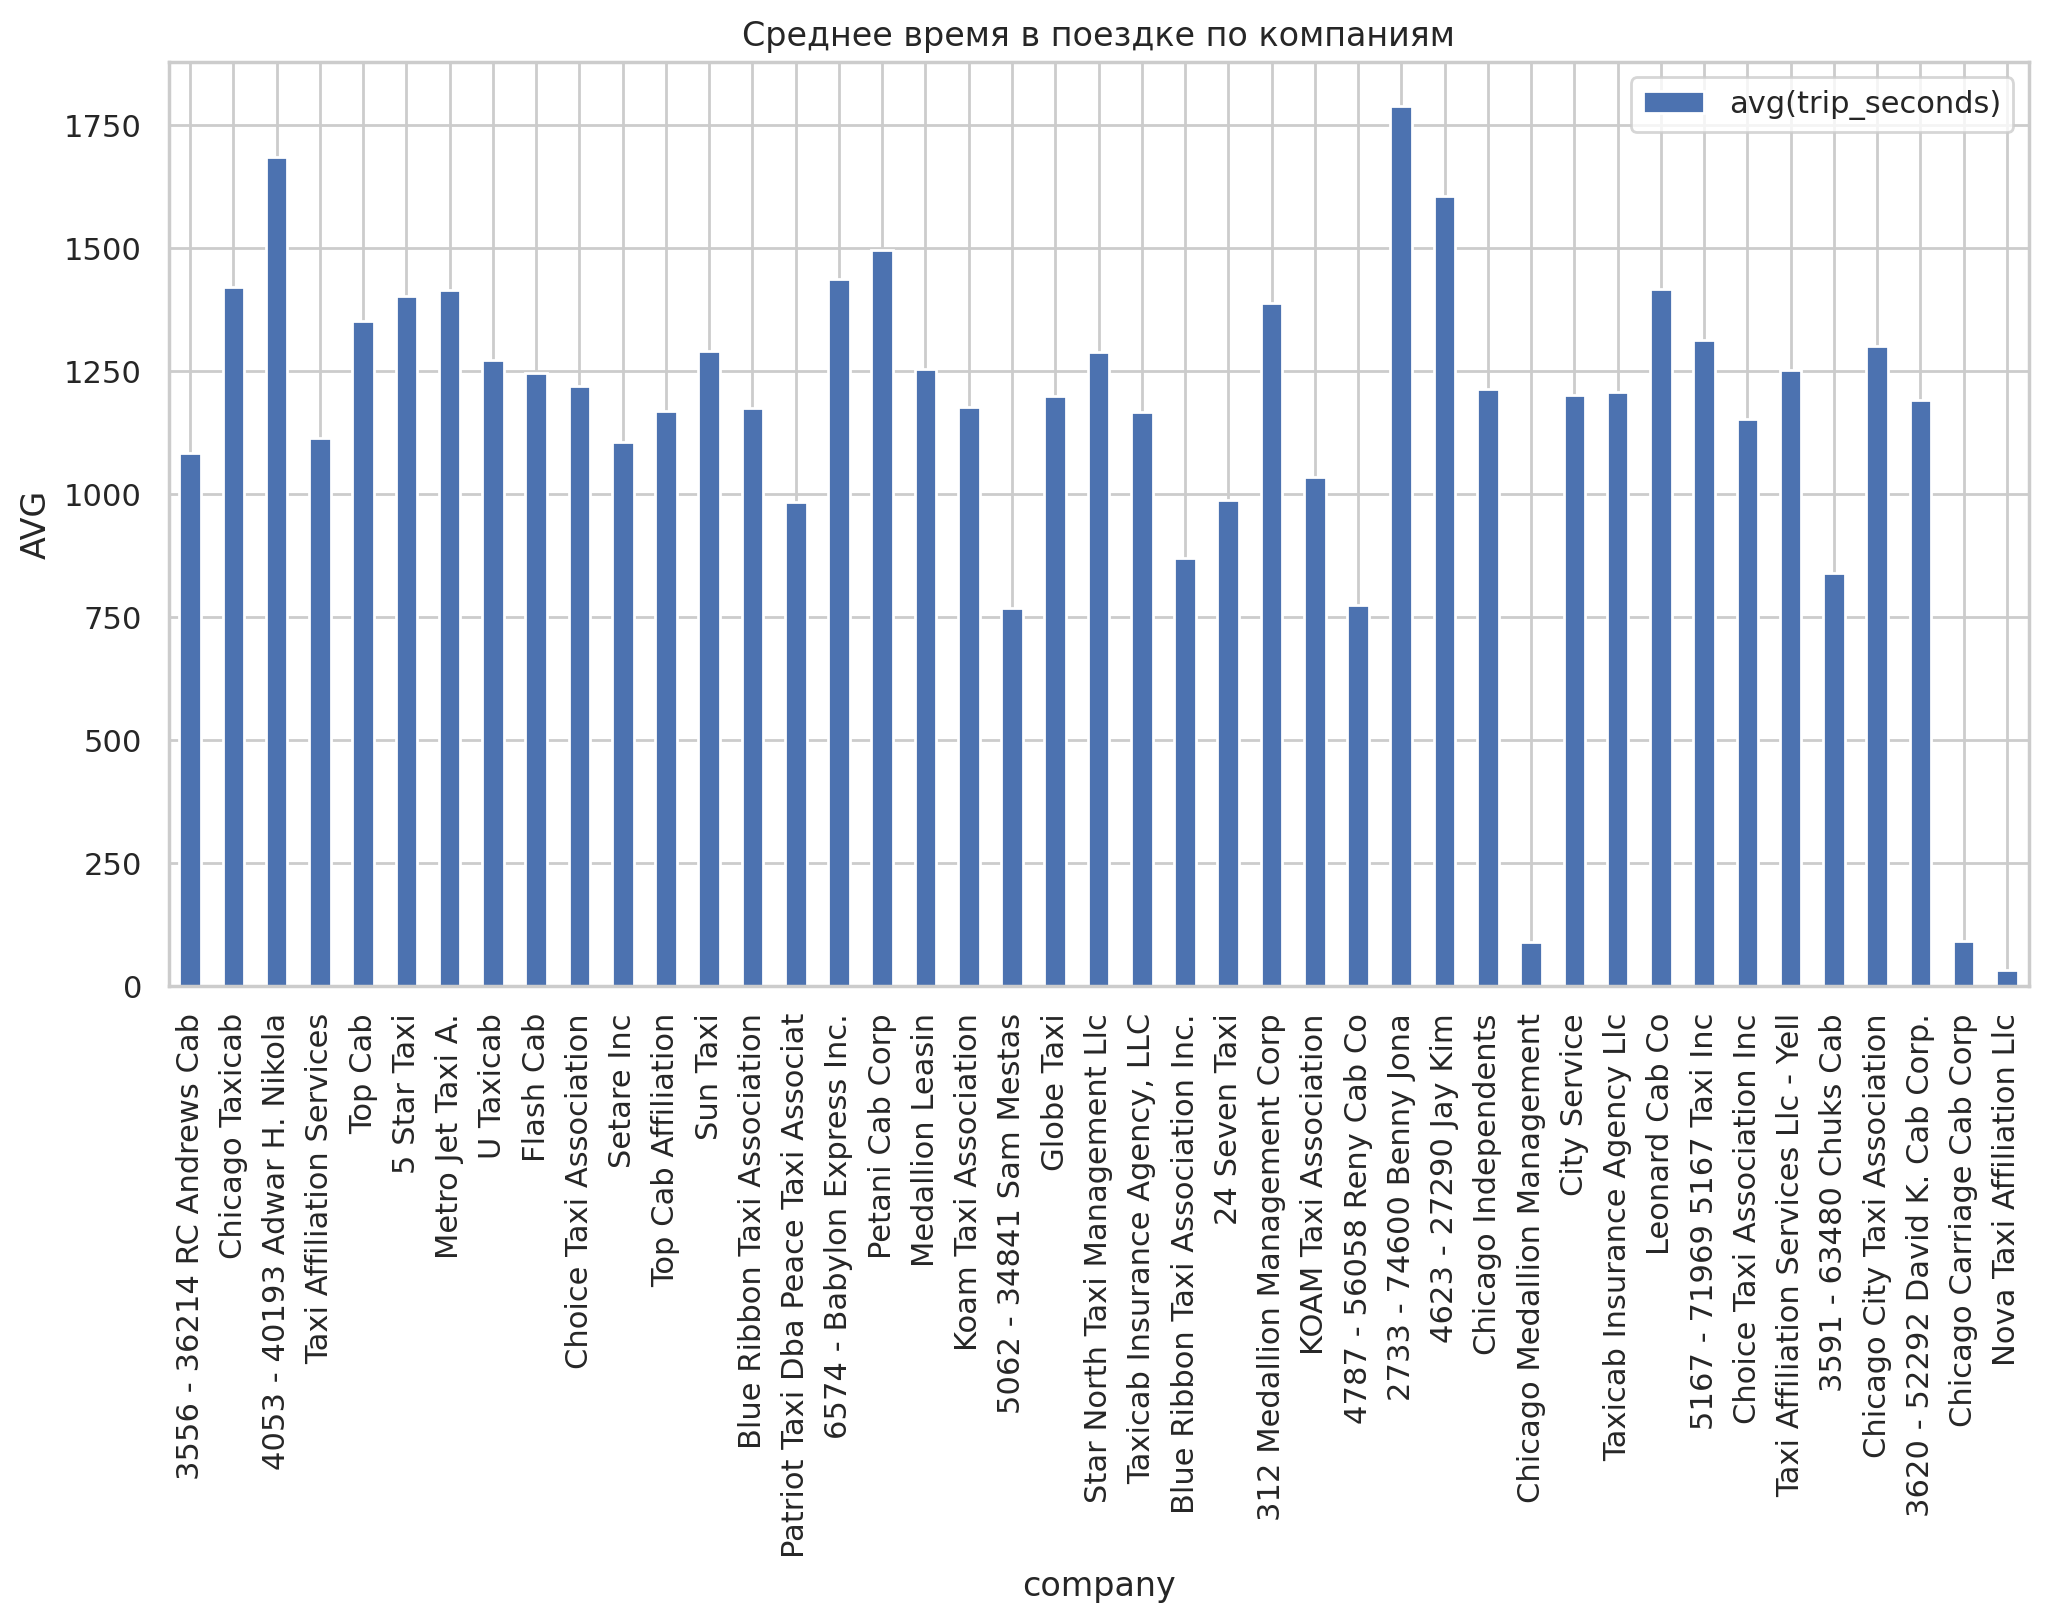

In [16]:

sec_df =  combained_data.select(['company', 
                                 'trip_seconds']
                               )\
                        .groupBy('company')\
                        .mean()\
                        .toPandas()

sec_df.plot(kind='bar', x='company', y=sec_df.columns.tolist()[1:], 
                         figsize=(12, 6), ylabel='AVG', xlabel='company')
plt.title('Среднее время в поездке по компаниям')
plt.show();

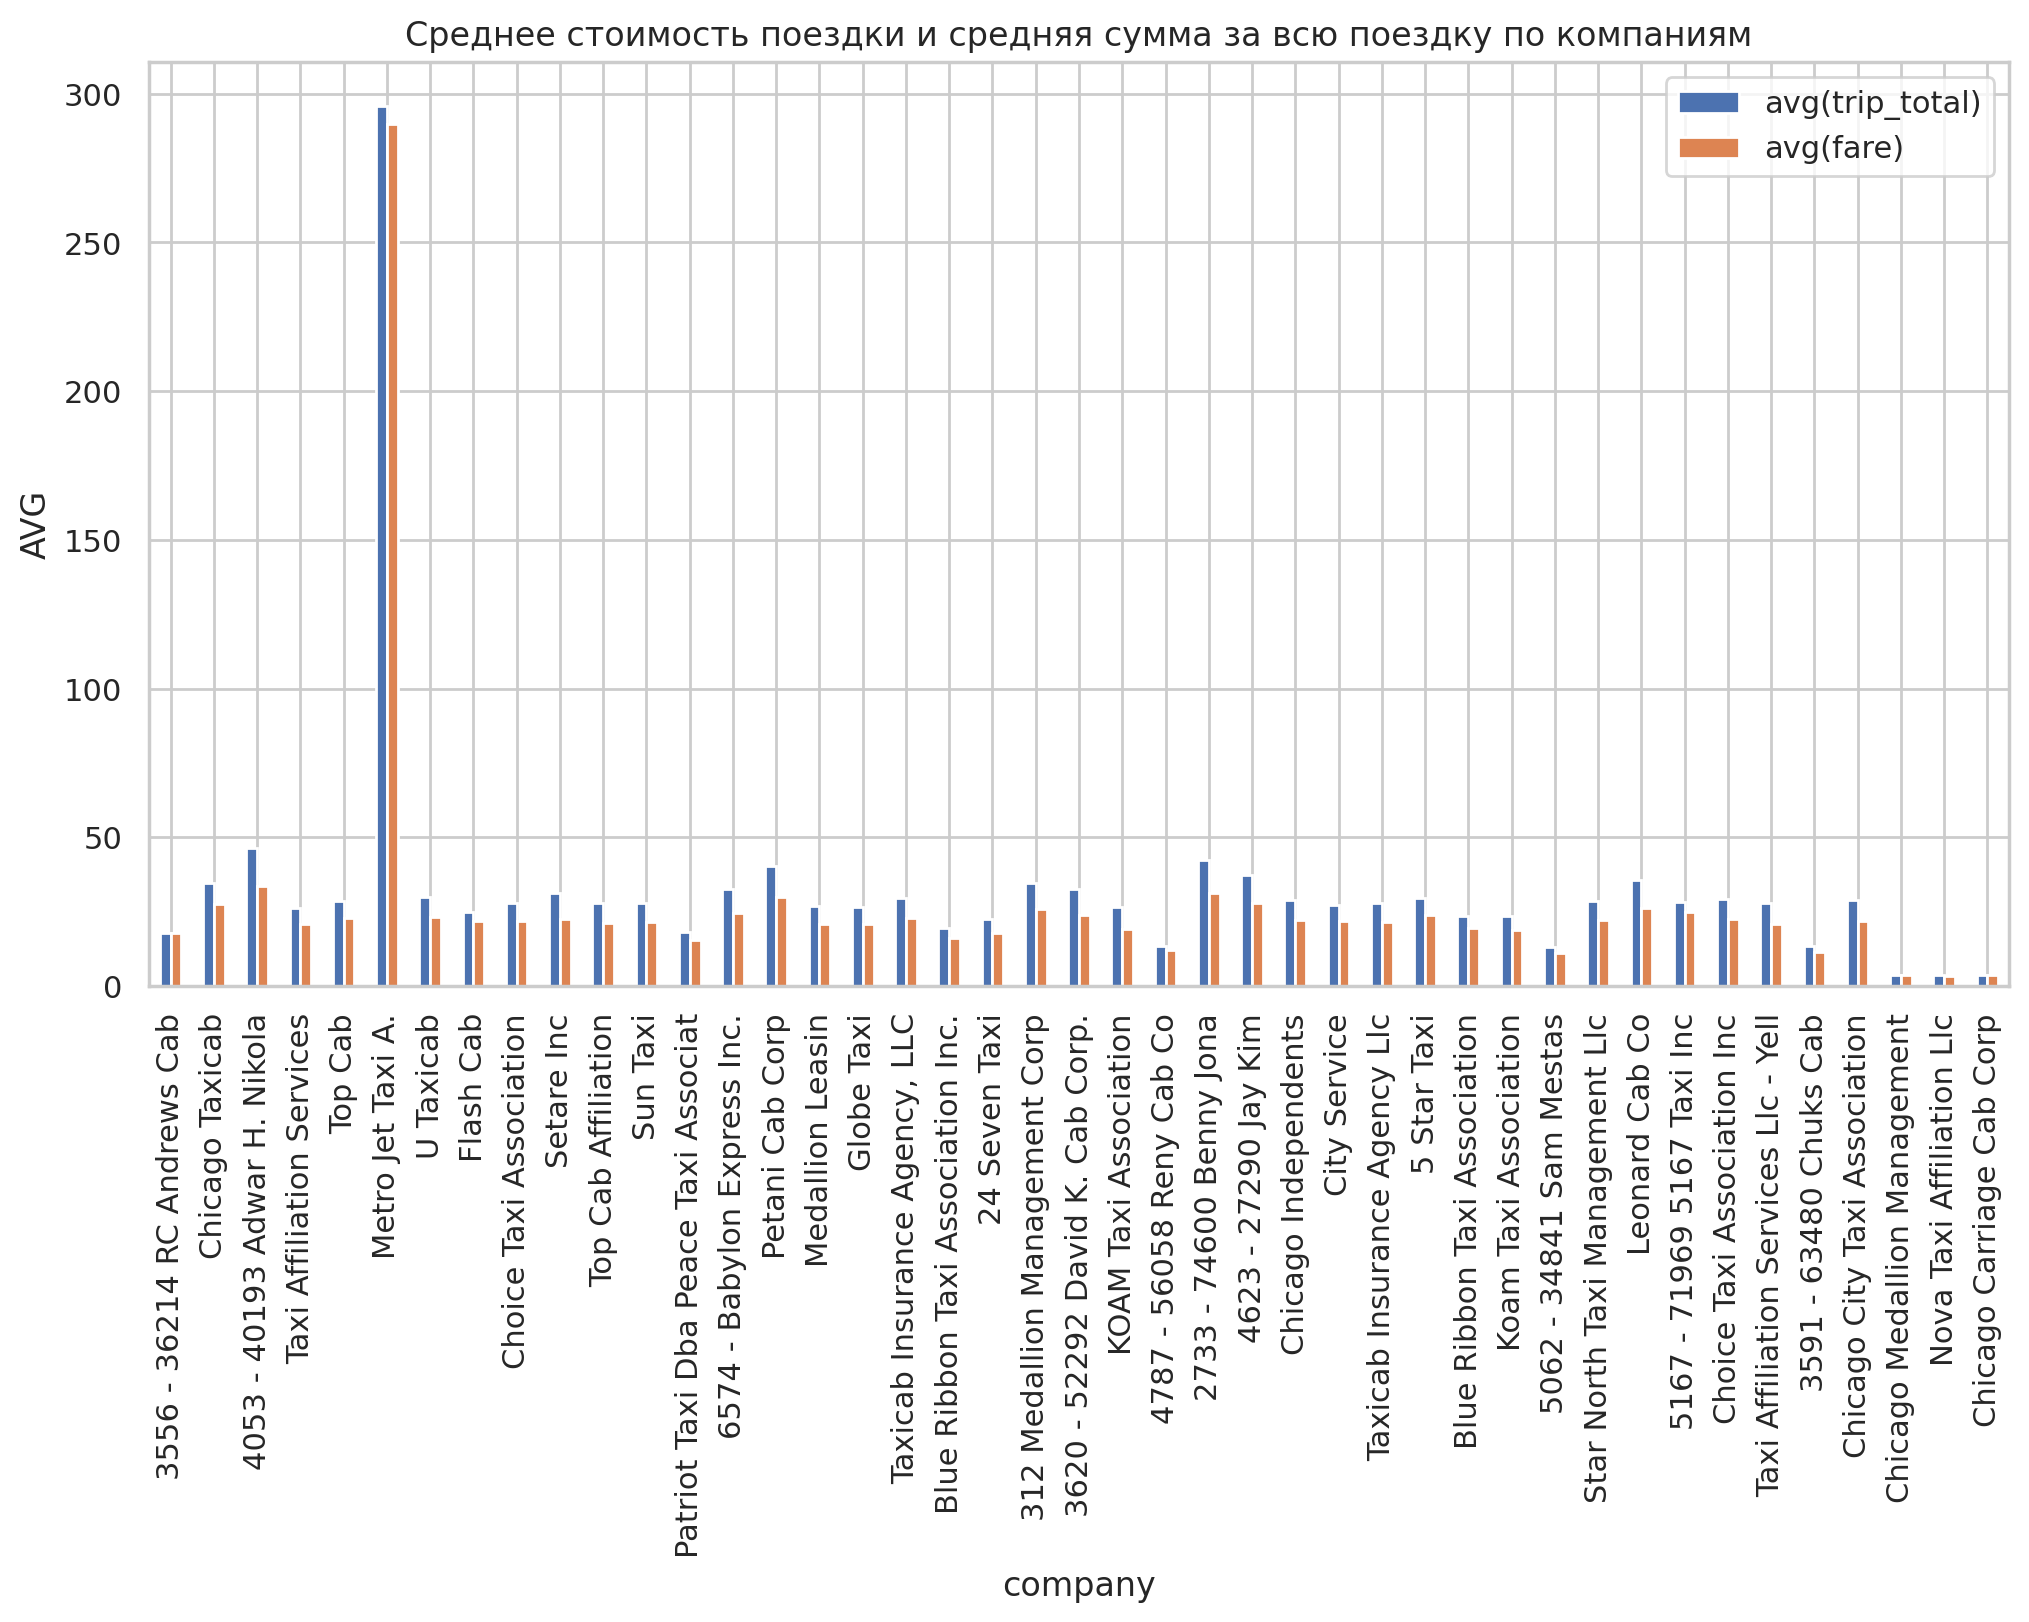

In [17]:

sec_df =  combained_data.select(['company', 
                                 'trip_total',
                                 'fare']
                               )\
                        .groupBy('company')\
                        .mean()\
                        .toPandas()


sec_df.plot(kind='bar', x='company', y=sec_df.columns.tolist()[1:], 
                         figsize=(12, 6), ylabel='AVG', xlabel='company')
plt.title('Среднее стоимость поездки и средняя сумма за всю поездку по компаниям')
plt.show();


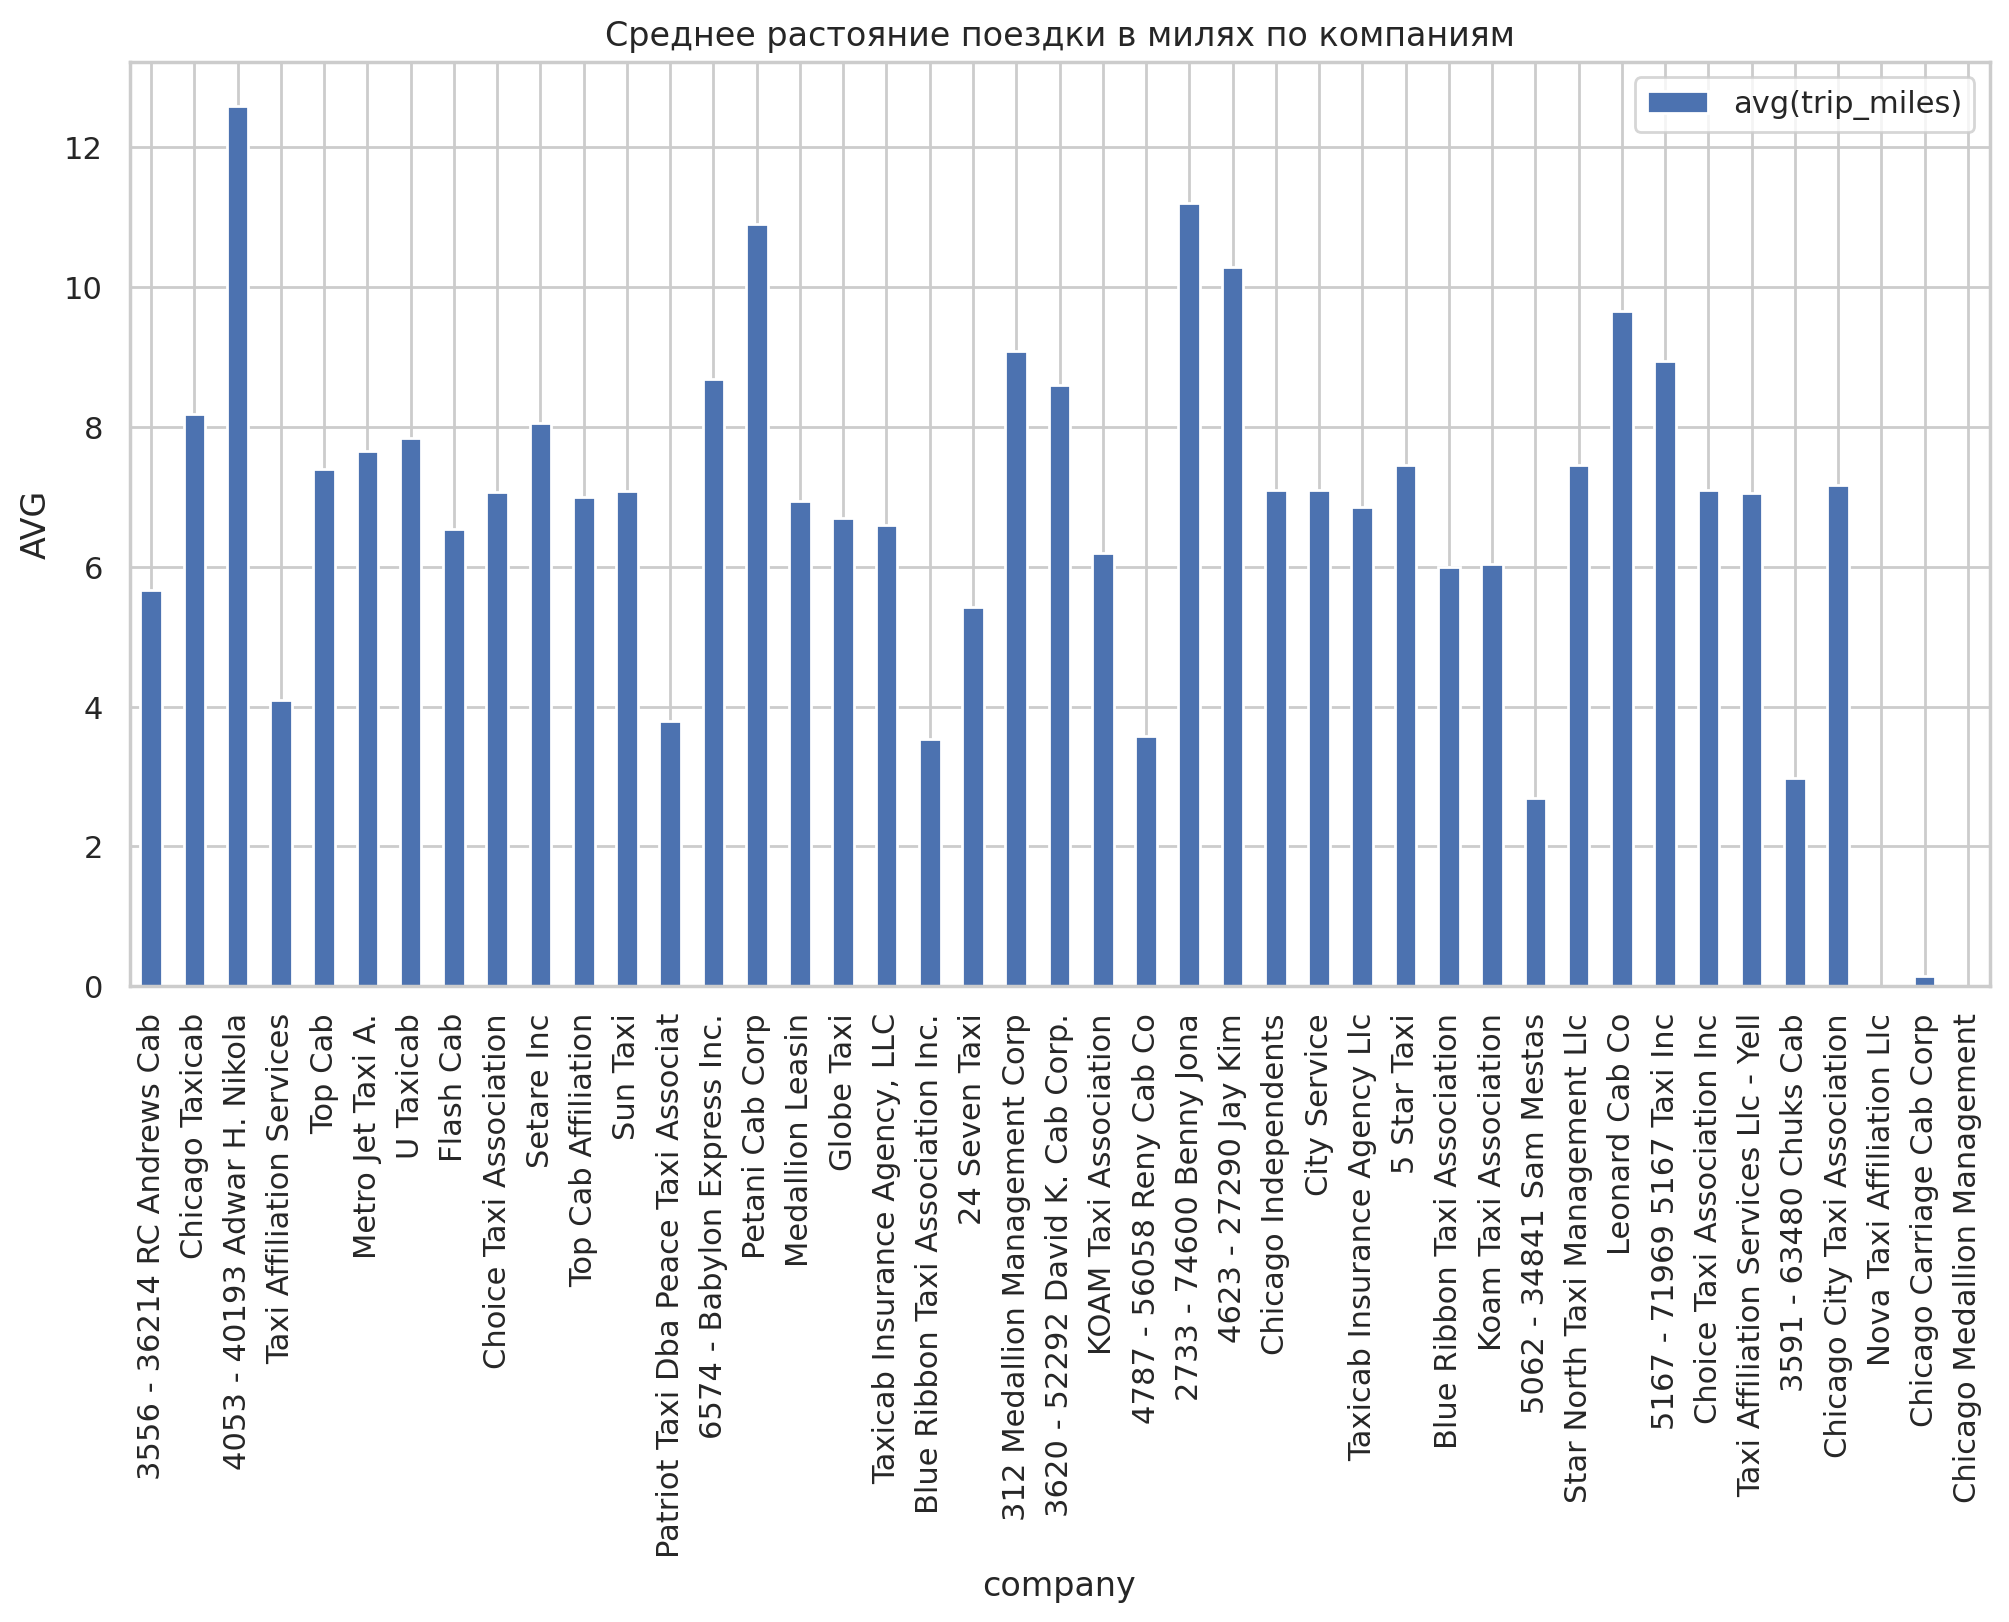

In [18]:

sec_df =  combained_data.select(['company', 
                                 'trip_miles']
                               )\
                        .groupBy('company')\
                        .mean()\
                        .toPandas()

sec_df.plot(kind='bar', x='company', y=sec_df.columns.tolist()[1:], 
                         figsize=(12, 6), ylabel='AVG', xlabel='company')
plt.title('Среднее растояние поездки в милях по компаниям')
plt.show();

После первичного анализа можно сказать что в данных есть излишние значения

В признаке 'company' есть такая фирма как Metro Jet Taxi A., на фоне остальных компаний ее значения могут показаться выбросами, но изучив материалы стало ясно что это компания в виде транспорта использует самолеты, от туда и такая высокая цена на среднюю поездку и вполне возможно что самый максимальный чек об оплате именно в этой комании.

Так же в 'company' есть фирмы Chicago Carriage Cab Corp, Chicago Medallion Management и Nova Taxi Affiliation LIc, их показатели крайне низкие, на фоне остальных компаний 

Вобщем и целом в данных есть поездки длинною в сутки или же на длительные растояния более 5000 миль, если подумать вполне возможно что такси могли орендовать на сутки, данные где аренда больше 24 часов нет, а супер большие растояния можно преодолеть на мамолете, но для более стабильных показателей проведем обработку данных где урежим максимальные показатели.

Чтобы проанализировать количества заказов во времени - агрегируем наши данные в почасовую выборку.

In [19]:
# приведем дату к нужному типу данных для дольнейшей работы.

combained_data = combained_data\
    .withColumn("start_timestamp", F.to_timestamp(
        F.col("trip_start_timestamp"),'MM/dd/yyyy hh:mm:ss a'))\
    .withColumn("end_timestamp", F.to_timestamp(
        F.col("trip_end_timestamp"),'MM/dd/yyyy hh:mm:ss a'))


In [20]:
#Построим график зависимости заказов такси по дням и часам


time_data = combained_data.groupBy(F.date_trunc('hour', F.col('start_timestamp')).alias('start_timestamp')).agg(F.count('trip_id').alias('trip_id_count'))\
                                                    .orderBy(F.col('start_timestamp'))



In [21]:
time_data = time_data.toPandas() 
time_data.set_index("start_timestamp", inplace=True)

In [22]:
# Выведем графики сезонности, треда, шума, и отобразим скользящую среднюю, предварительно сделав ресемплинг в 1 день

time_data = time_data.resample('1D').sum()
decomposed = seasonal_decompose(time_data['trip_id_count'])

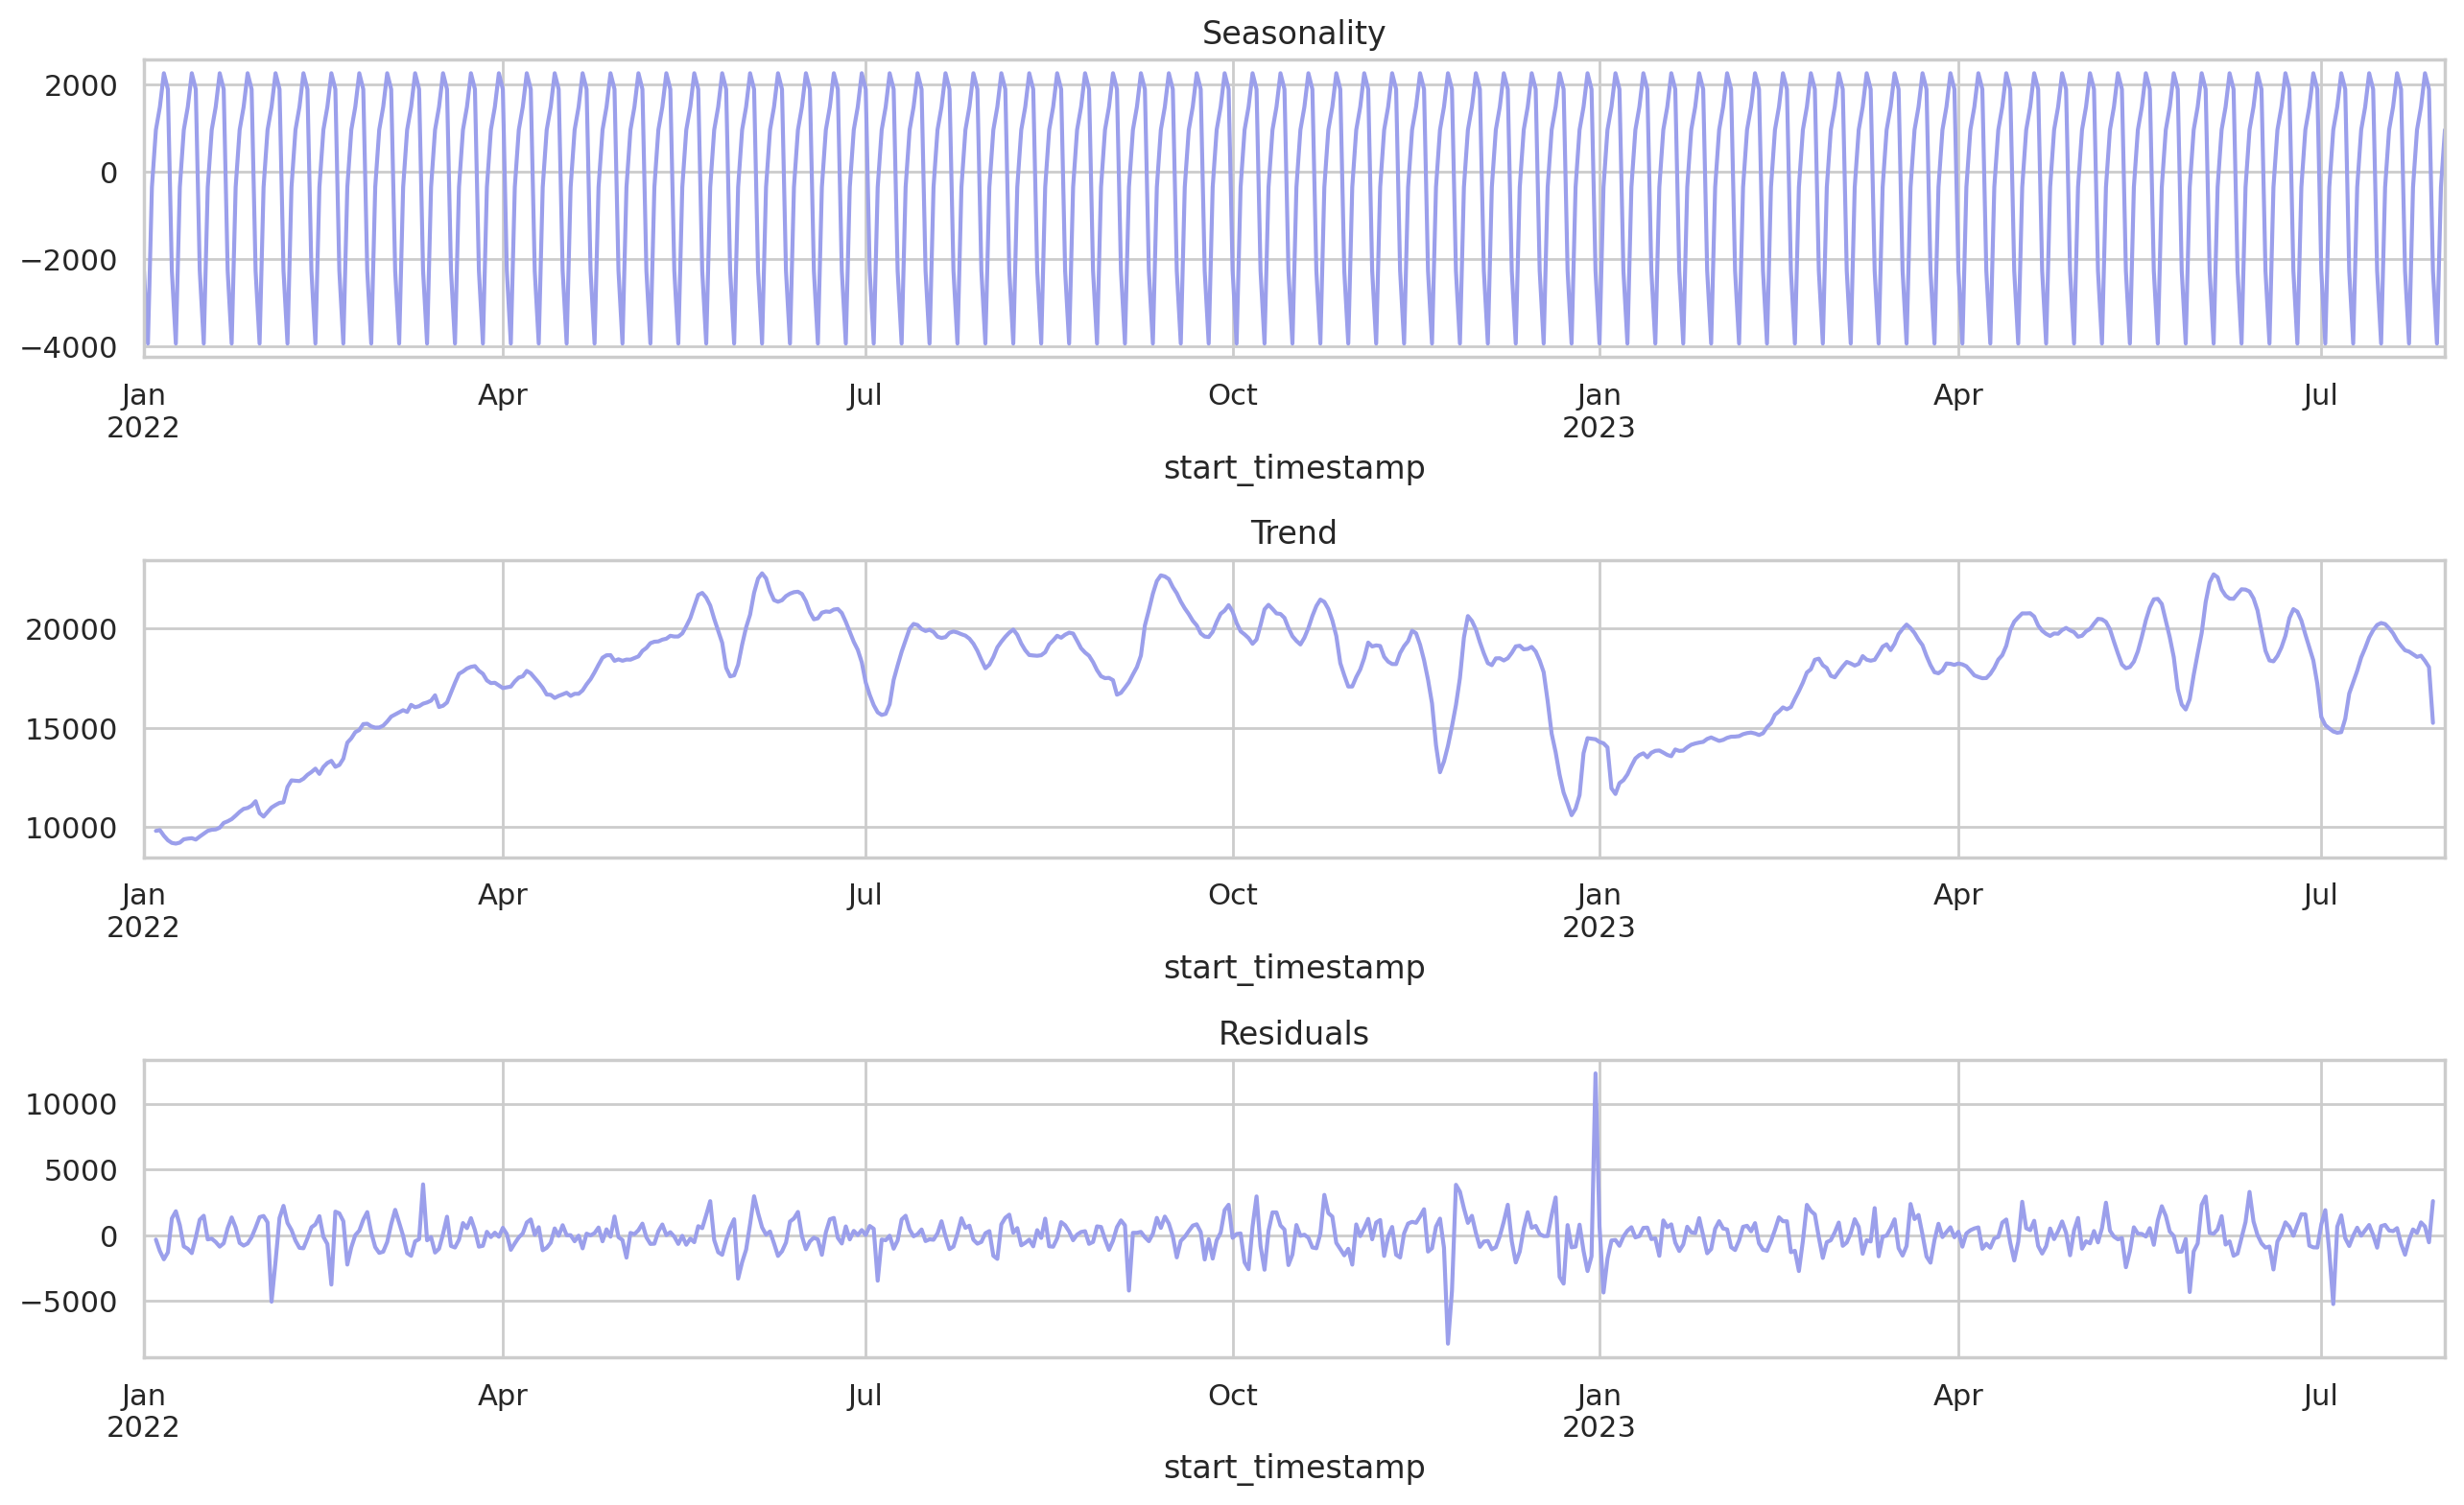

In [23]:
plt.figure(figsize=(13, 8))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca(), color='#9b9feb')
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca(), color='#9b9feb')
plt.title('Trend')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='#9b9feb')
plt.title('Residuals')
plt.tight_layout()
plt.show();

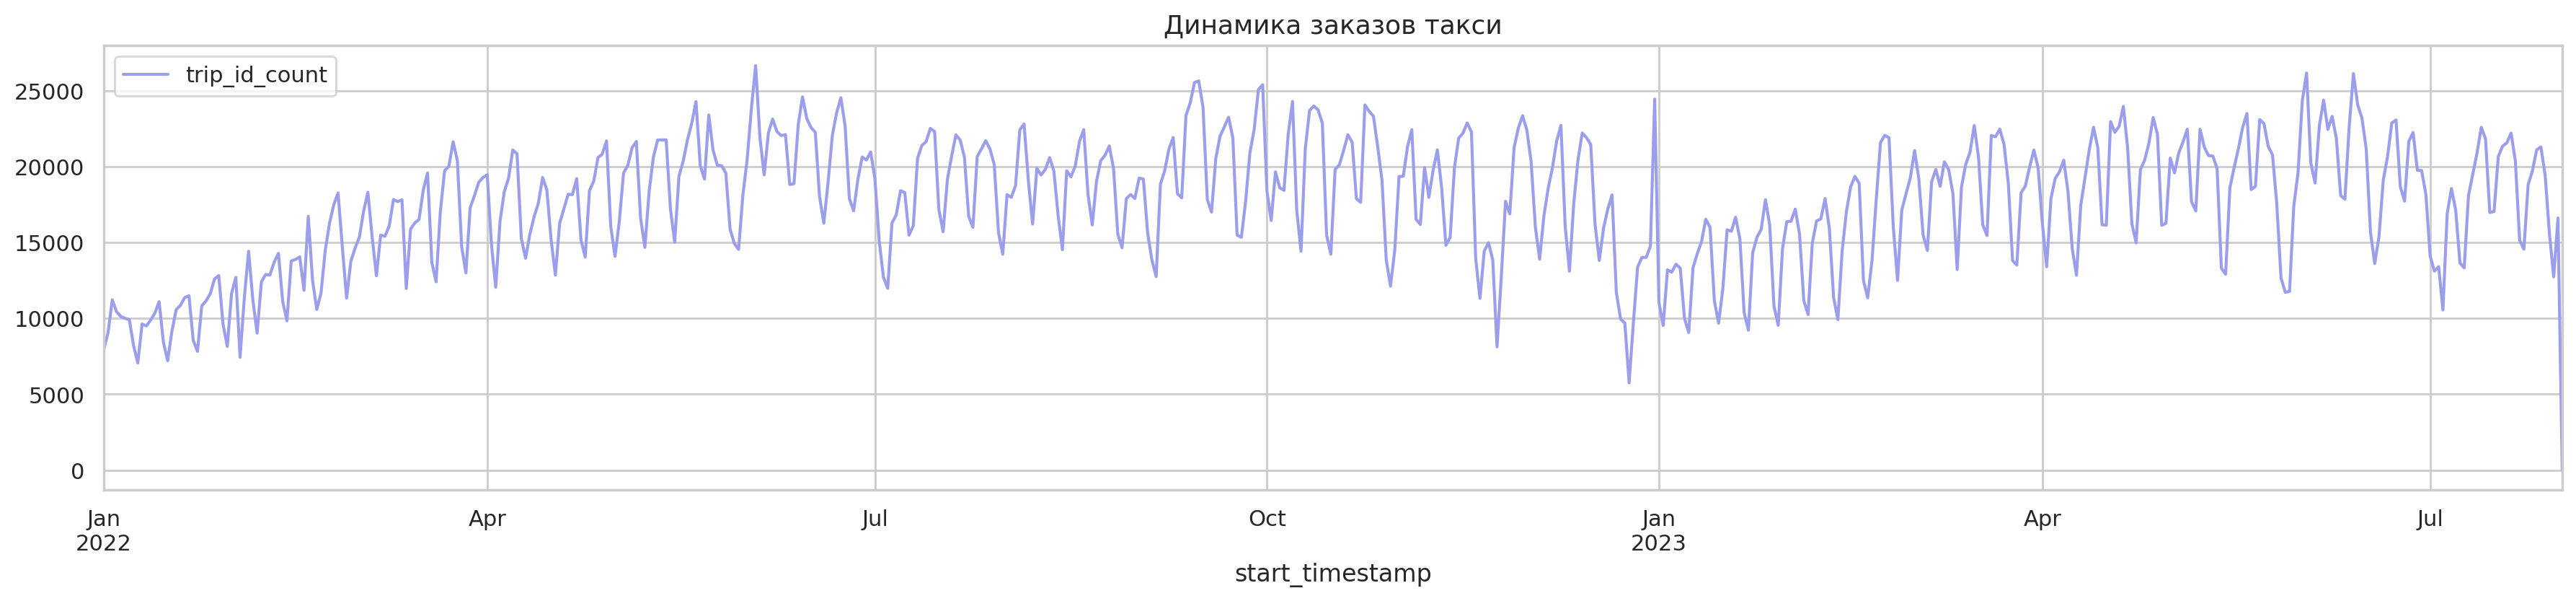

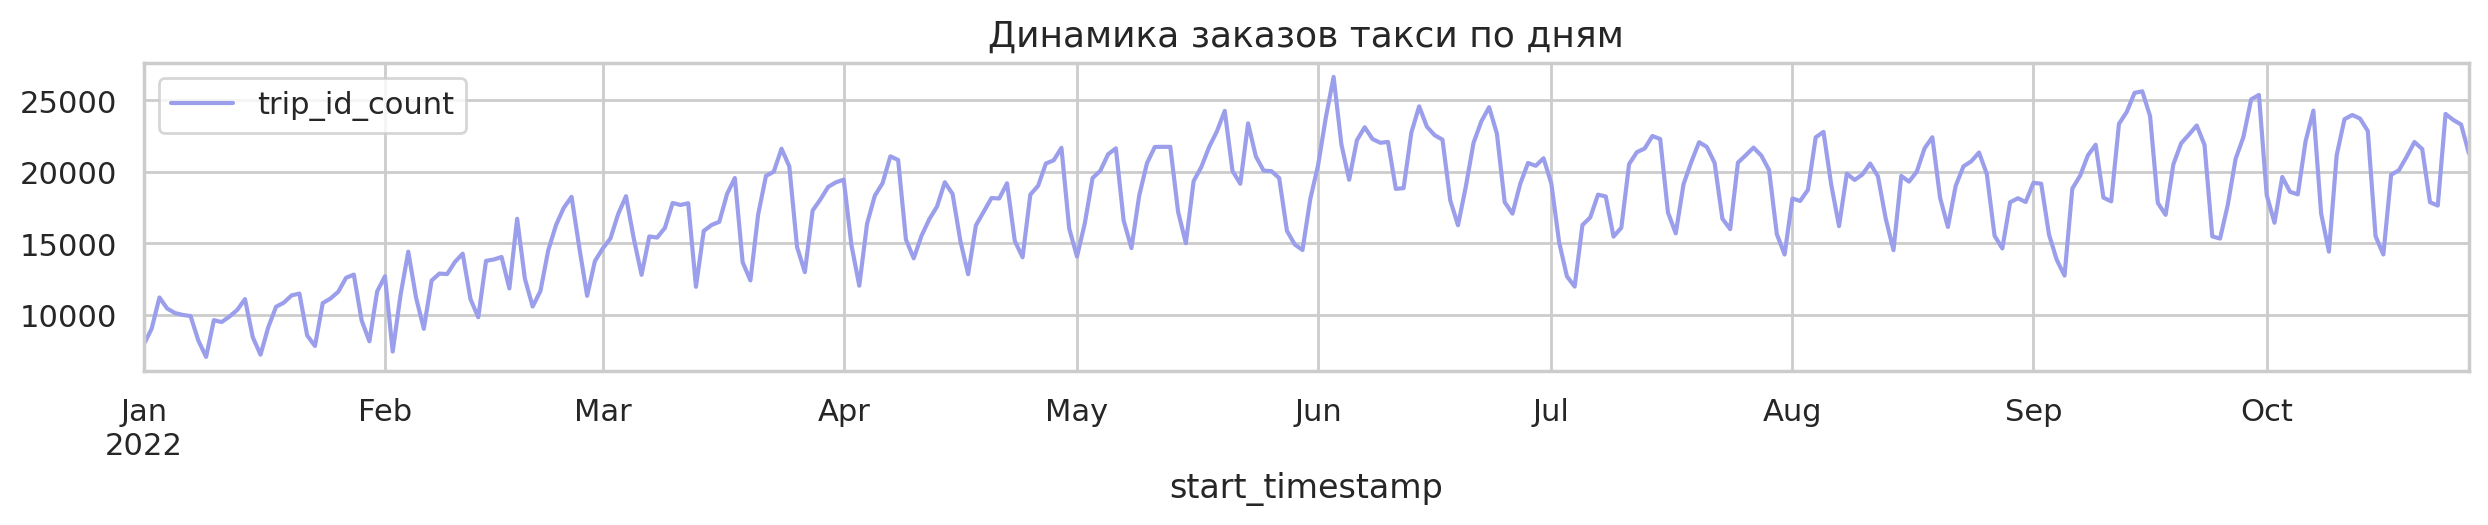

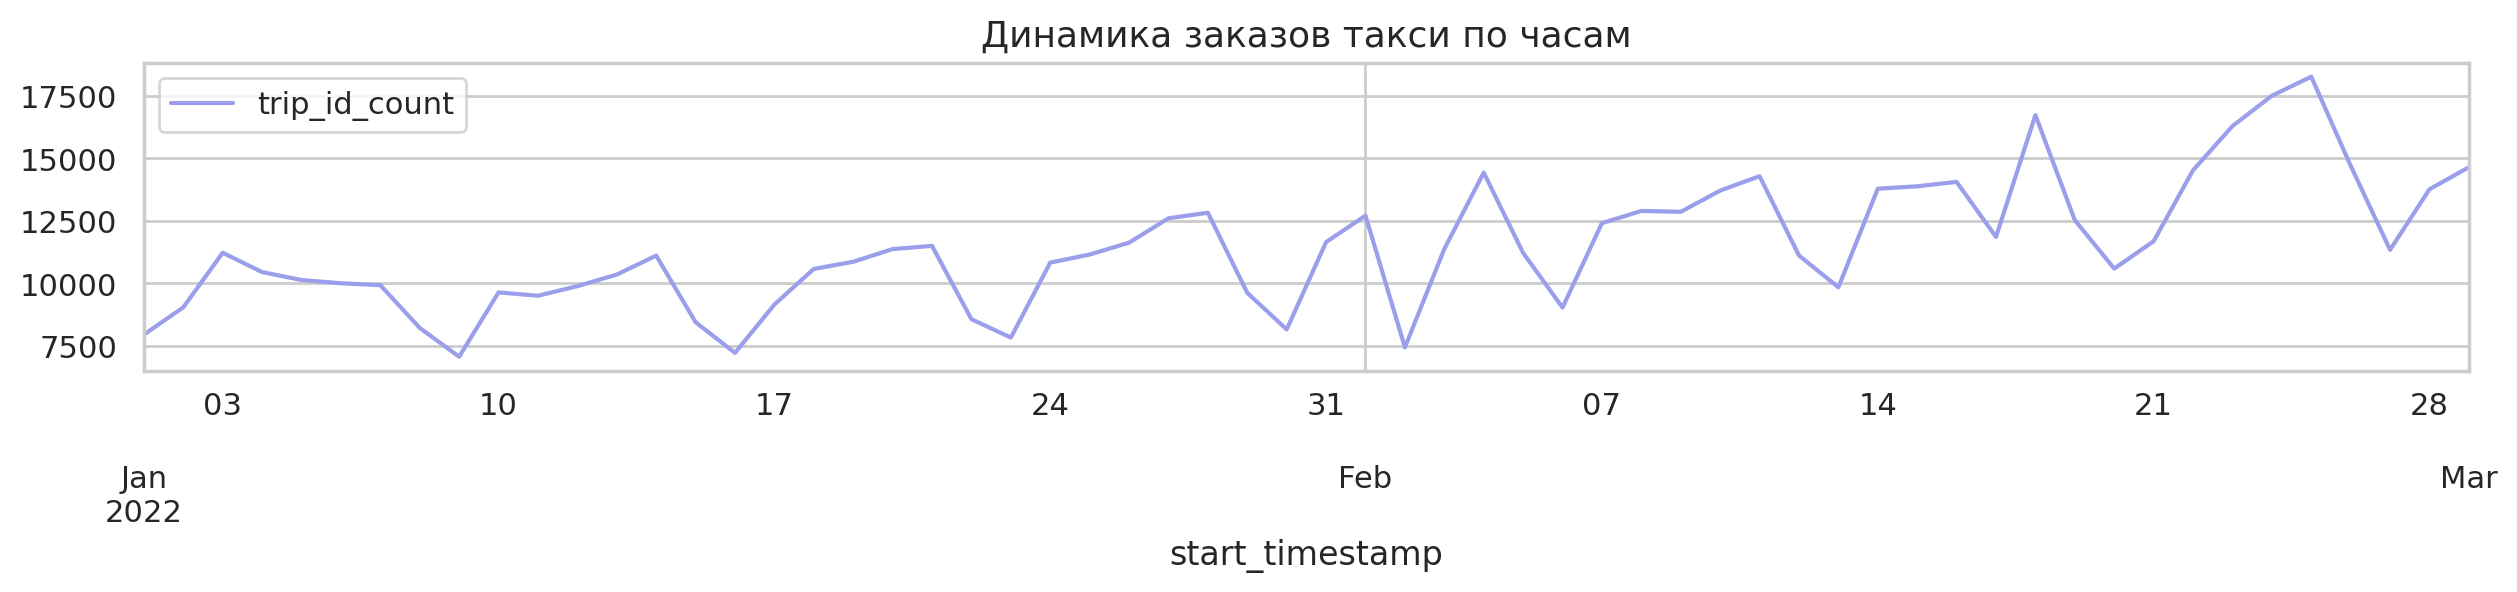

In [24]:
time_data[:9000].plot(y="trip_id_count", use_index=True, figsize=(22, 4), color='#9b9feb')
plt.title('Динамика заказов такси', fontsize=13);

time_data[:300].plot(y="trip_id_count", use_index=True, figsize=(15, 2), color='#9b9feb')
plt.title('Динамика заказов такси по дням', fontsize=13);

time_data[:60].plot(y="trip_id_count", use_index=True, figsize=(15, 2), color='#9b9feb')
plt.title('Динамика заказов такси по часам', fontsize=13);

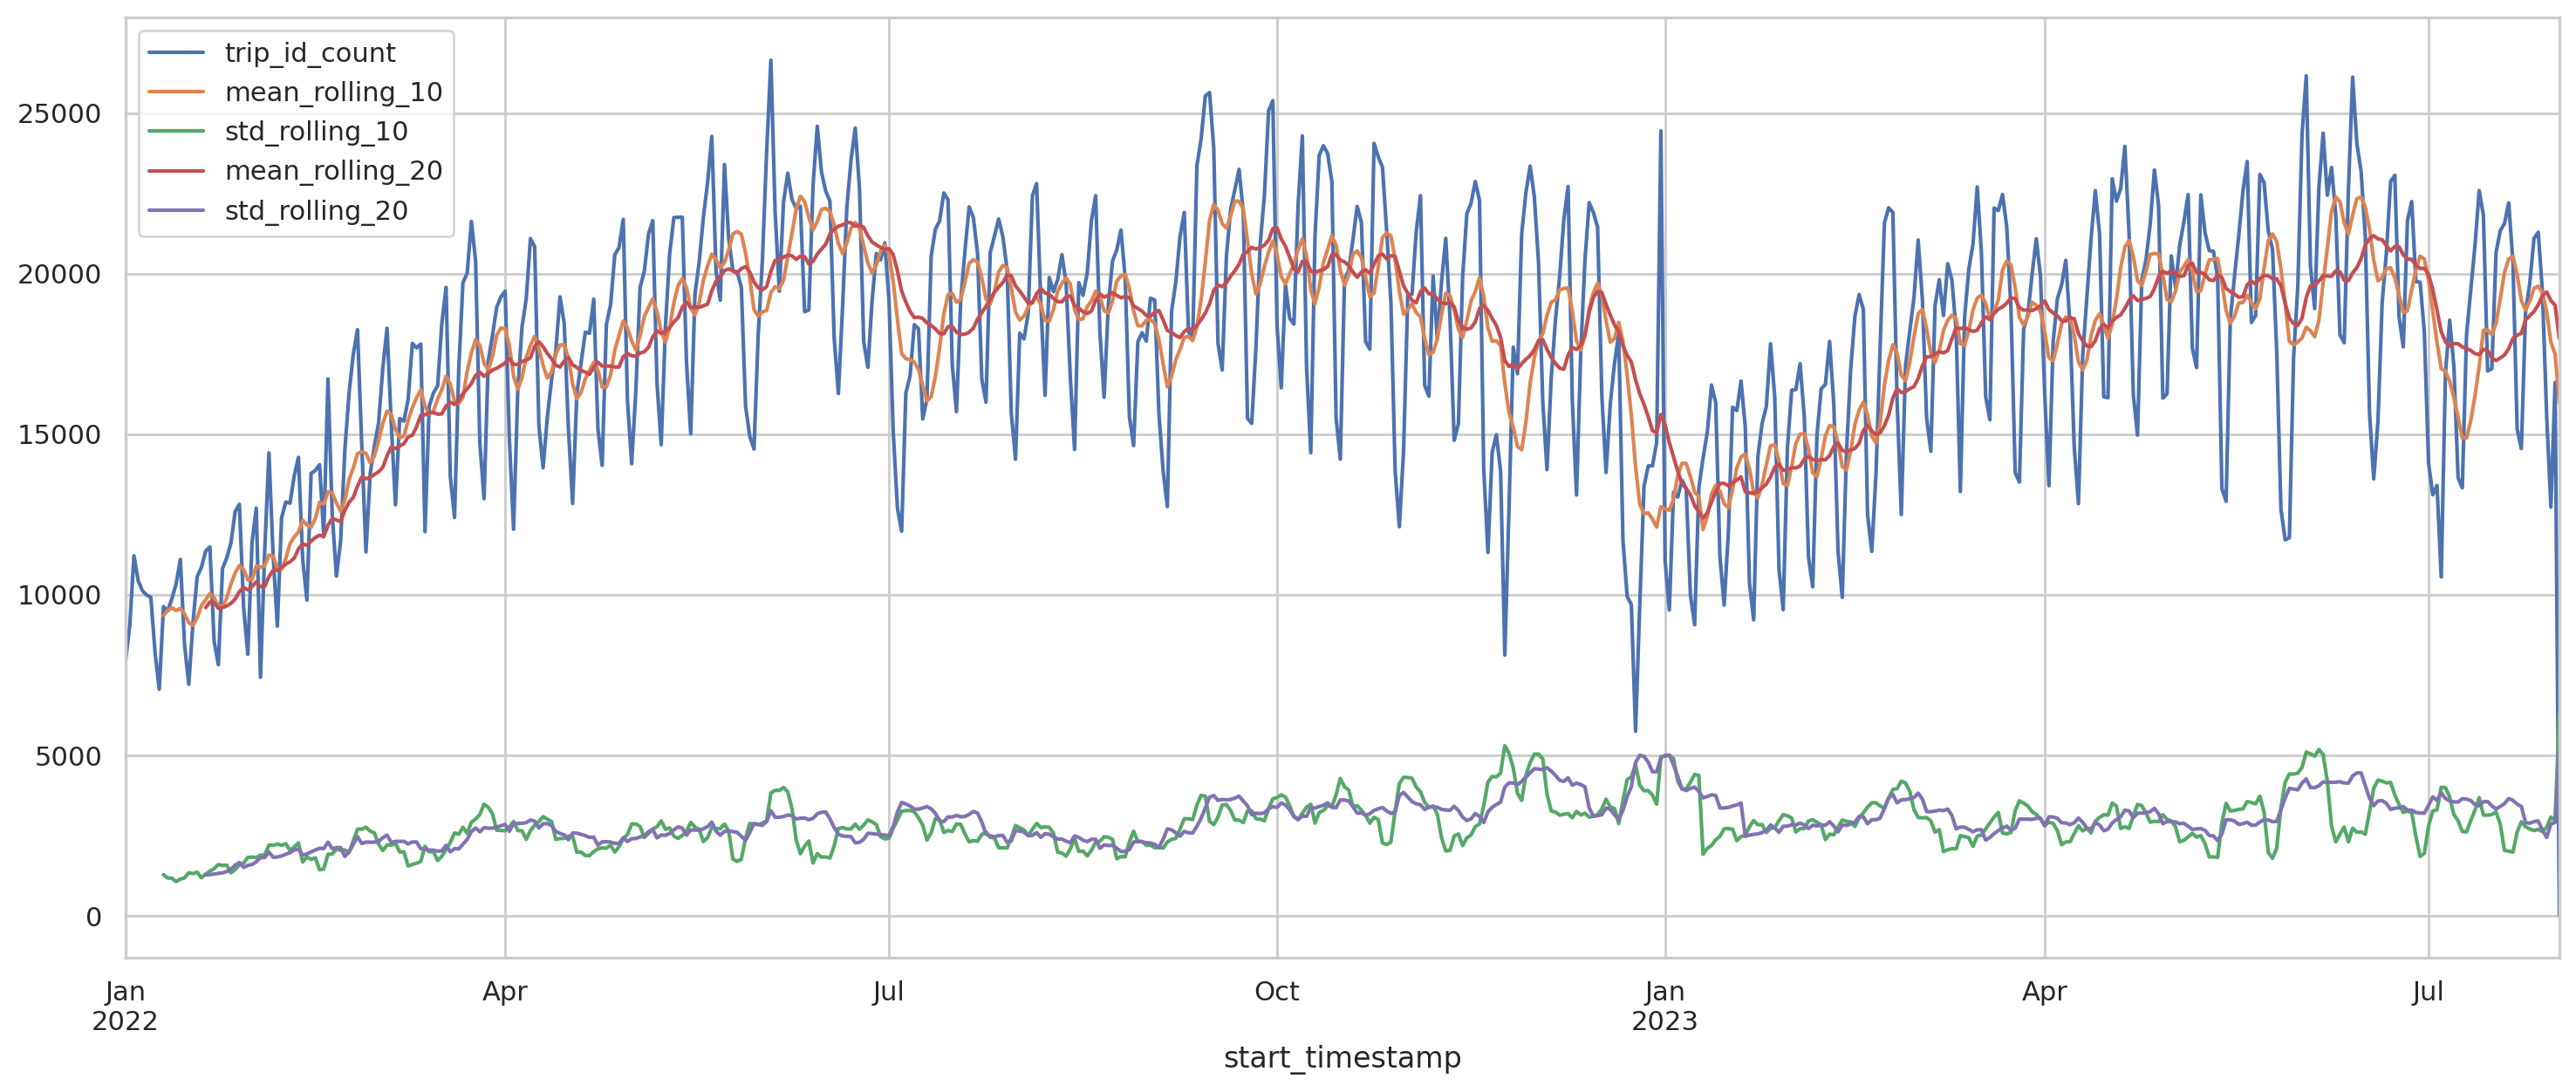

In [25]:
time_data['mean_rolling_10'] = time_data['trip_id_count'].rolling(10).mean()
time_data['std_rolling_10'] = time_data['trip_id_count'].rolling(10).std()
time_data['mean_rolling_20'] = time_data['trip_id_count'].rolling(20).mean()
time_data['std_rolling_20'] = time_data['trip_id_count'].rolling(20).std()
time_data.plot(figsize=(18,7))
plt.show();

Мы видим, что временной ряд не стационарен. 
Поговорим отдельно по графикам:

- На тренде и так же на динамике заказов мы видим изменения в течении года. Зимой общее количество заказов меньше, постепенно возрастает к апрелю и держится на высоком уровне до декабря и начинает снижаться к минимуму в январе.
- Если рассмотреть сезонные явления в течении недели показано на графике 'Динамика заказов такси по дням' - явно заметно увеличение количества заказов днём, особенно к вечеру и уменьшение их ранним утром. Видны падения заказов такси по выходным, c увеличением в будние дни. Наблюдаются пики заказов по понедельникам, вторникам и пятницам.
- На графике 'Динамика заказов такси по часам' пик заказов такси наблюдается в вечернее время в районе 17-19 часов

## 5. Предварительная обработка данных

С этой информацией, которую мы собрали в результате нашего разведочного анализа данных, мы знаем достаточно, чтобы предварительно обработать наши данные, чтобы передать их в модель.

+ Все нулевые значения в необходимых признаках были исключены из набора данных.
+ Вероятно, нам следует стандартизировать наши данные, так как мы видели, что диапазон минимальных и максимальных значений довольно велик.

В связи с сильно ограниченным количеством памяти на локальной машине, пересоздадим spark сессию перед работой с моделями машинного обучения.

In [26]:
spark.catalog.clearCache()
spark.stop()
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.task.cpus", 1) \
    .getOrCreate()

data = spark.read.csv(path=['Taxi_Trips_-_2022.csv', 'Taxi_Trips_-_2023.csv'], schema=schema, header=True)


In [27]:
# Для начала разделим данные на обучающую валидационную и тестовые выборки и проведём предварительную обработку данных.

data = data.select('trip_start_timestamp',
                   'trip_seconds',
                   'trip_miles',
                   'pickup_community_area',
                   'fare',
                   'tips',
                   'extras')

data = data.withColumn('trip_start_timestamp', F.to_timestamp(col('trip_start_timestamp'),'MM/dd/yyyy hh:mm:ss a'))
data = data.withColumn('rank', F.percent_rank().over(Window.orderBy('trip_start_timestamp')))
data = data.dropna()
data = data.filter(~((col('trip_seconds') == 0) & (col('trip_miles') != 0)))
data = data.filter(~((col('trip_seconds') == 0) & (col('trip_miles') == 0)))

data_train = data.where('rank <= .6').drop('rank')
data_valid = data.where('rank > .6 AND rank <= .8').drop('rank')
data_test = data.where('rank > .8').drop('rank')

In [28]:
def filter_outliers(dataframe, columns, factor=1.5):
    for column in columns:
        quantiles = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        dataframe = dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    return dataframe

In [29]:
%%time
for part in tqdm(['train',
                  'valid',
                  'test']):
    globals()[f'data_{part}'] = filter_outliers(globals()[f'data_{part}'], ['trip_seconds',
                                                                            'trip_miles',
                                                                            'fare',
                                                                            'tips',
                                                                            'extras'], factor=3)



100%|██████████| 3/3 [06:31<00:00, 130.58s/it]

CPU times: user 771 ms, sys: 115 ms, total: 886 ms
Wall time: 6min 31s


In [30]:
# После очистки даных напишем функцию которая будет выдавать порегионные агрегированные по часу данные о поездках.

def get_region_data(data, region):
    data = data.filter(col('pickup_community_area') == region) \
        .drop('pickup_community_area') \
        .groupBy(F.date_trunc('hour', 'trip_start_timestamp').alias('hour')) \
        .agg(F.count('*').alias('orders'),
             F.avg('trip_seconds').alias('avg_trip_seconds'),
             F.avg('trip_miles').alias('avg_trip_miles'),
             F.avg('fare').alias('avg_fare'),
             F.avg('tips').alias('avg_tips'),
             F.avg('extras').alias('avg_extras')).sort('hour', ascending=True)
    return data

## 6. Фичи инжиниринг

Фичи-инжиниринг или “Feature Engineering” - это процесс создания новых признаков (features) из имеющихся данных для улучшения эффективности моделей машинного обучения. Это очень важный этап в подготовке данных, так как от качества и количества признаков может зависеть точность модели.
Фичи-инженеры занимаются преобразованием имеющихся данных в более полезную форму, которая поможет модели лучше понять и предсказать поведение объектов или событий. Они могут создавать новые признаки на основе существующих данных, извлекать полезные характеристики из сложных структур данных или даже создавать совершенно новые признаки из комбинации существующих.


В результате фичи-инжиниринга модель получает более качественные и полезные данные для обучения, что позволяет ей лучше понимать и анализировать взаимосвязи между признаками и целевым значением, а также улучшает точность и эффективность модели.

In [31]:
# Напишем функцию генерирующую новые признаки.

def make_features(data, max_lag, rolling_mean_size):

    data = data.withColumn('month', F.month(col('hour')))
    data = data.withColumn('day', F.dayofmonth(col('hour')))
    data = data.withColumn('day_of_week', F.dayofweek(col('hour')))
    w = Window.orderBy('hour')
    
    for lag in range(1, max_lag + 1):
        data = data.withColumn('lag_{}'.format(lag), F.lag('orders', lag).over(w))
    data = data.withColumn('lag_week', F.lag('orders', 7 * 24).over(w))
    w = Window.orderBy('hour').rowsBetween(-1 - rolling_mean_size,-1)
    data = data.withColumn('rolling_mean_{}'.format(rolling_mean_size), F.avg('orders').over(w))
    data = data.dropna()
    return data
    

In [32]:

%%time
for part in ['train', 'valid', 'test']: # Создадим порегионные наборы данных.
    for region in tqdm(range(1, 78)):
        globals()[f'data_{part}_{region}'] = make_features(get_region_data(globals()[f'data_{part}'].sort('trip_start_timestamp'), region), 24, 24).cache()



100%|██████████| 77/77 [00:24<00:00,  3.15it/s]

CPU times: user 4.06 s, sys: 1.92 s, total: 5.98 s
Wall time: 1min 6s


## 7. Обработка признаков

In [33]:
# Для линейной модели категориальные данные будем обрабатывать OHE, а числовые данные отшкалируем.

cat_cols = ['month', 'day' ,'day_of_week']
num_cols = ['lag_{}'.format(c + 1) for c in range(24)] +\
           ['lag_week', 'rolling_mean_24'] +\
           ['avg_trip_seconds', 'avg_trip_miles', 'avg_fare', 'avg_tips', 'avg_extras']



In [34]:
encoder = OneHotEncoder(inputCols=cat_cols, outputCols=[c + '_ohe' for c in cat_cols])
numerical_assembler = VectorAssembler(inputCols=num_cols, outputCol='numerical_features')
scaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_features_scaled')
final_assembler = VectorAssembler(inputCols=encoder.getOutputCols() + ['numerical_features_scaled'], outputCol='features')

## 8. Создание модели машинного обучения с помощью Spark ML

После завершения предварительной обработки пришло время приступить к построению нашей модели линейной регрессии! Как всегда, нам сначала нужно разделить данные на обучающие, валидационную и тестовую выборку.

Для вычисления MAE (средняя абсолютная ошибка) в pyspark можно использовать класс RegressionEvaluator из модуля pyspark.ml.evaluation.


### Linear Regression

**Создайте модель ElasticNet:**

ElasticNet — это модель линейной регрессии, предварительно обученная с использованием L1 и L2 в качестве регуляризатора. Эта комбинация позволяет изучать разреженную модель, в которой несколько весов не равны нулю, как у Лассо, при этом сохраняя свойства регуляризации Риджа. Мы управляем выпуклой комбинацией L1 и L2, используя параметр l1_ratio.

Эластичная сеть полезна, когда есть несколько функций, которые коррелируют друг с другом. Lasso, скорее всего, выберет один из них случайным образом, в то время как эластичная сеть, скорее всего, выберет оба.

Практическое преимущество компромисса между Lasso и Ridge заключается в том, что он позволяет Elastic-Net унаследовать некоторую стабильность Ridge при вращении.

Целевая функция для минимизации в этом случае:
\begin{align}
min_w\frac{1}{2n_{samples}}{\parallel{X_w - y}\parallel}^2_2 + \alpha\lambda{\parallel{X_w - y}\parallel}_1 + \frac{\alpha(1-\lambda)}{2}{\parallel{w}\parallel}^2_2
\end{align}

http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [35]:

lr = (LinearRegression(featuresCol='numerical_features_scaled', labelCol="orders", 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [36]:
pipeline_lr = Pipeline(stages=[encoder, numerical_assembler, scaler, final_assembler, lr])

In [37]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='orders', metricName='mae')

In [38]:
%%time
score_lr = {}
for region in tqdm(range(1, 78)):
    globals()[f'model_lr_{region}'] = pipeline_lr.fit(globals()[f'data_train_{region}'])
    score_lr[region] = evaluator.evaluate(globals()[f'model_lr_{region}'].transform(globals()[f'data_valid_{region}']).select('orders', 'prediction'))



100%|██████████| 77/77 [1:31:32<00:00, 71.34s/it]

CPU times: user 14.7 s, sys: 2.85 s, total: 17.5 s
Wall time: 1h 31min 32s


In [39]:
pd.Series(score_lr).describe()

count    77.000000
mean      2.105014
std       3.749873
min       0.126437
25%       0.586333
50%       0.943443
75%       1.788570
max      20.250977
dtype: float64

### Gradient-boosted tree regression

Деревья с градиентным усоцом (GBT) - это популярный метод классификации и регрессии с использованием ансамблей деревьев принятия решений. Более подробную информацию о реализации spark.ml можно найти в разделе [GBT](https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-trees-gbts).

Опишем процесс обучения, как и в Linear Regression создается пустой словарь score_gb и цикл for для итерации по всем элементам в указанном диапазоне (от 1 до 78). Внутри цикла создаются переменные model_gb_регион и data_train_регион с использованием встроенной функции globals(). Затем модель pipeline_gb обучается на датасете data_train и сохраняется в переменную model_gb.

После обучения модели, вызывается функция evaluate для оценки качества модели на валидационных данных data_valid. Результаты оценки сохраняются в словаре score_gb с ключом регион. В конце каждого цикла словарь score_gb обновляется с новой оценкой модели.



In [40]:
assembler = VectorAssembler(inputCols=(num_cols + cat_cols), outputCol='features')

In [41]:
gb = GBTRegressor(featuresCol='features', labelCol='orders', seed=rnd_seed)

In [42]:
pipeline_gb = Pipeline(stages=[assembler, gb])

In [43]:
%%time
score_gb = {}
for region in tqdm(range(1, 78)):
    globals()[f'model_gb_{region}'] = pipeline_gb.fit(globals()[f'data_train_{region}'])
    score_gb[region] = evaluator.evaluate(globals()[f'model_gb_{region}'].transform(globals()[f'data_valid_{region}']).select('orders', 'prediction'))
    

100%|██████████| 77/77 [09:26<00:00,  7.35s/it]

CPU times: user 4.37 s, sys: 1.03 s, total: 5.4 s
Wall time: 9min 26s


In [44]:
pd.Series(score_gb).describe()

count    77.000000
mean      1.810919
std       3.398576
min       0.117032
25%       0.488530
50%       0.763377
75%       1.355091
max      19.570895
dtype: float64

In [54]:
# Объединим метрики, посмотрим на результаты

result = pd.concat({"LinearRegression": pd.Series(score_lr).describe(),
                    "GBTRegressor": pd.Series(score_gb).describe()}, axis = 1)
result

,LinearRegression,GBTRegressor
count,77.000000,77.000000
mean,2.105014,1.810919
std,3.749873,3.398576
min,0.126437,0.117032
25%,0.586333,0.488530
50%,0.943443,0.763377
75%,1.788570,1.355091
max,20.250977,19.570895


## Тестирование лучшей модели 

GBTRegressor показал лучшие показатели, посмотрим на его результаты на тестовой выборке, объединив данные из train и valid.

In [46]:
%%time
score_gb_test = {}
for region in tqdm(range(1, 78)):
    globals()[f'model_gb_{region}'] = pipeline_gb.fit(globals()[f'data_train_{region}'].union(globals()[f'data_valid_{region}']))
    try:
        score_gb_test[region] = evaluator.evaluate(globals()[f'model_gb_{region}'].transform(globals()[f'data_test_{region}']).select('orders', 'prediction'))
    except:
        score_gb_test[region] = None

100%|██████████| 77/77 [2:16:21<00:00, 106.25s/it]   

CPU times: user 16.1 s, sys: 2.22 s, total: 18.3 s
Wall time: 2h 16min 21s


In [47]:
pd.Series(score_gb_test).describe()

count    76.000000
mean      2.099973
std       4.733138
min       0.144653
25%       0.433644
50%       0.676230
75%       1.271754
max      30.437581
dtype: float64

In [75]:
spark.stop()

## Вывод

В проекте "Прогнозирование спроса на заказы такси с помощью Apache Spark" мы провели исследование на данных поездок в Чикаго за 2022 и 2023 года и перед нами стояла задача предсказать количество заказов на следующий час в каждом округе.

Работа над проектом проводилась на локально развёрнутом Spark-кластере из Docker-контейнеров.

Все работы были выполнены согласно данного плана, новых действий не потребовалось.

Отмечу ключивые моменты:

- При загрузке данных проблем не возникло, определили ход работы и ясно познакомились с данными.
- Основным этапом стал этап разведочный анализ данных, в ходе первичного анализа были выявелны пропуски в данных, в этом пункте с помощью визуализации мы получили примерный портрет таксопарков и ситуации по заказам, далее на вход модели данные подали без аномалий, в противном случае метрика была бы искажена.
- Так же не маловажный этап предварительная обработка данных, тут мы провели основную зачиству на основе информации с предыдущих этапов, это позволило подготовить данные для фичиинженеринга.
- После фичиинженеринга была проведена кодировка данных, на этом этапе так же проблем не возникло.
- Работа с моделями оказалась самым простым этапом, выбранные инструменты помогли избавиться от ненужного кода и ускорить работу модели.

Лучшие показатели были получены на модели GBTRegressor, модель была обучена на объединённых данных (train + valid) и пртестированы на тестовой выборке для проверки адекватности результатов.

В результате при помощи обработки даных получилось улучшить значение метрики, была зафиксирована цель значение метрики MAE ~ 1.5, но нужного качества пока что я не достиг, мои показатели таковы :
 - count    76.000000
 - mean      2.099973
 - std       4.733138
 - min       0.144653
 - 25%       0.433644
 - 50%       0.676230
 - 75%       1.271754
 - max      30.437581

Какие идеи для улучшения результата я на данный момент вижу:

- попробовать выделить новые признаки на основе имеющихся;

- попытаться найти закономерности в других признаках;

- попробовать другие ML-модели.

